In [61]:
import numpy as np
import colour
import matplotlib.pyplot as plt

In [62]:
cvd = 'Deuteranomaly'
M = colour.blindness.matrix_cvd_Machado2009(cvd, 1)

def compute_kernel(M):
    s, V = np.linalg.eig(M)

    idx = s.argsort()
    s = s[idx]
    V = V[:,idx]

    v = V.T[0]
    v = v / np.linalg.norm(v)
    print('Eigenvalues:', s)
    print('First eigenvector:', v)
    return v

v = compute_kernel(M)

Eigenvalues: [  5.73655225e-07   1.00000585e+00   1.00869758e+00]
First eigenvector: [ 0.92205474 -0.38601936  0.02835681]


In [63]:
def comute_anchor_points(v):
    cube_vertices = [np.array([0, 0, 0]), np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]), np.array([1, 1, 0]), np.array([1, 0, 1]), np.array([0, 1, 1]), np.array([1, 1, 1])]
    center = np.array([1/2, 1/2, 1/2])

    max_distance = 0
    max_idx = 0
    for idx, vertex in enumerate(cube_vertices):
        distance = np.linalg.norm(center + v - vertex)
        if distance > max_distance:
            max_distance = distance
            max_idx = idx
        print(vertex, distance)

    anchor_1 = cube_vertices[max_idx]
    anchor_2 = np.ones(3) - anchor_1
    print(f'Anchor 1: {anchor_1}, Anchor 2: {anchor_2}')
    return anchor_1, anchor_2

anchor_1, anchor_2 = comute_anchor_points(v)

[0 0 0] 1.5213126543
[1 0 0] 0.685771616398
[0 1 0] 1.75682409776
[0 0 1] 1.50255734394
[1 1 0] 1.11459473719
[1 0 1] 0.643093375434
[0 1 1] 1.74060831037
[1 1 1] 1.08885619246
Anchor 1: [0 1 0], Anchor 2: [ 1.  0.  1.]


In [64]:
def compute_basis(v, anchor_1, anchor_2):
    basis = [np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1])]

    max_scalar = 0
    max_idx = 0
    for idx, vertex in enumerate(basis):
        if np.abs(np.dot(vertex, v)) > max_scalar:
            max_scalar = np.dot(vertex, v)
            max_idx = idx
        print(vertex, np.abs(np.dot(vertex, v)))

    n = basis[max_idx]
    e_y, e_z = [basis[i] for i in range(len(basis)) if i != max_idx]
    print(f'Normal: {n}, e_y: {e_y}, e_z: {e_z}')

    d = 1 / np.abs(np.dot(n, v))
    print(f'Distance: {d}')

    y = e_y * np.dot(anchor_2 - (anchor_1 + d * v), e_y)
    z = e_z * np.dot(anchor_2 - (anchor_1 + d * v), e_z)
    print(f'y: {y}, z: {z}')
    return d, y, z

d, y, z = compute_basis(v, anchor_1, anchor_2)

[1 0 0] 0.922054741146
[0 1 0] 0.386019359163
[0 0 1] 0.0283568101653
Normal: [1 0 0], e_y: [0 1 0], e_z: [0 0 1]
Distance: 1.084534307320623
y: [-0.         -0.58134876 -0.        ], z: [ 0.          0.          0.96924607]


In [73]:
s = 1
for t_y, t_z in ((0,0), (1, 0), (0, 1), (1, 1), (0.5, 0.5)):
    x = anchor_1 + d/2 * v + t_y * y + t_z * z
    color_1 = x + s*d/2 *v
    color_2 = x - s*d/2 *v
    print(t_y, t_z)
    print(tuple((255 * color_1).astype(int)), tuple((255 * color_2).astype(int)))
    print(tuple((255 * M@color_1).astype(int)), tuple((255 * M@color_2).astype(int)))

0 0
(255, 148, 7) (0, 255, 0)
(219, 171, 10) (219, 171, 10)
1 0
(255, 0, 7) (0, 106, 0)
(91, 71, 4) (91, 71, 4)
0 1
(255, 148, 255) (0, 255, 247)
(163, 183, 250) (163, 183, 250)
1 1
(255, 0, 255) (0, 106, 247)
(35, 83, 244) (35, 83, 244)
0.5 0.5
(255, 74, 131) (0, 180, 123)
(127, 127, 127) (127, 127, 127)


In [66]:
def compute_parallelepiped(v, anchor_1, anchor_2, d, y, z):
    parallelepiped_vertices = [
        anchor_1,
        anchor_2,
        anchor_1 + d * v,
        anchor_2 - d * v,
        anchor_1 + y,
        anchor_2 - y,
        anchor_1 + z,
        anchor_2 - z,
        anchor_1 + d * v + y,
        anchor_2 - d * v + y,
        anchor_1 + d * v + z,
        anchor_2 - d * v + z
    ]

    parallelepiped_edges = [
        [0, 2],
        [0, 4], 
        [0, 6],
        [1, 3],
        [1, 5],
        [1, 7],
        [2, 5],
        [2, 7],
        [3, 4],
        [3, 6],
        [4, 7],
        [5, 6]
    ]
    return parallelepiped_vertices, parallelepiped_edges

def compute_x_area(v, anchor_1, anchor_2, d, y, z):
    x_area_vertices = [
        anchor_1 + d/2 * v,
        anchor_1 + d/2 * v + y,
        anchor_1 + d/2 * v + z,
        anchor_2 - d/2 * v,
    ]

    x_area_edges = [
        [0, 1],
        [0, 2],
        [1, 3],
        [2, 3]
    ]
    return x_area_vertices, x_area_edges

parallelepiped_vertices, parallelepiped_edges = compute_parallelepiped(v, anchor_1, anchor_2, d, y, z)
x_area_vertices, x_area_edges = compute_x_area(v, anchor_1, anchor_2, d, y, z)

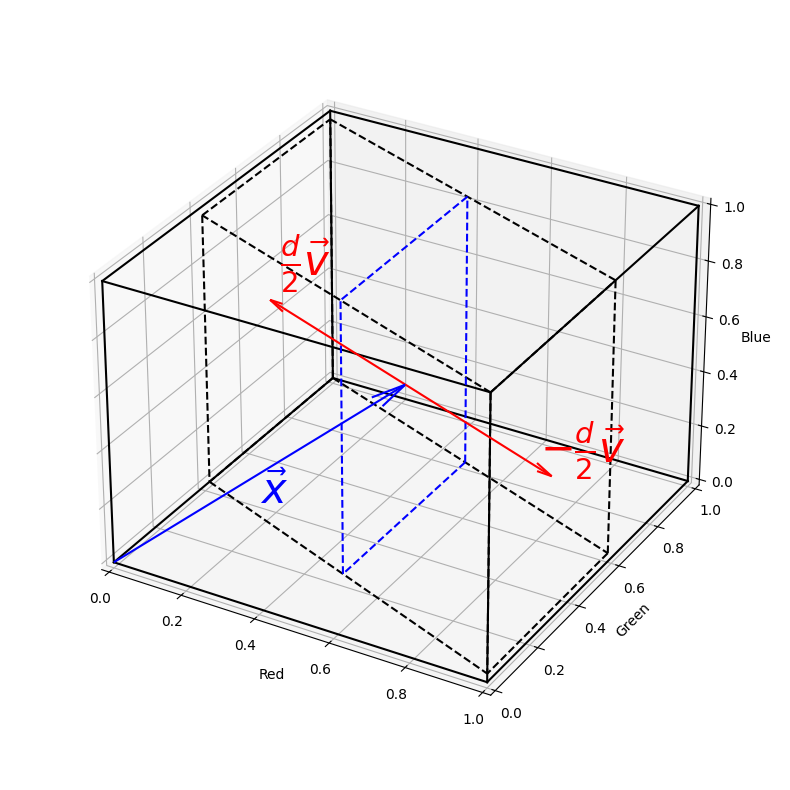

In [67]:
def create_figure():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_box_aspect(aspect=None, zoom=0.9)
    return ax

def plot_cube(ax):

    cube_vertices = [
        [0, 0, 0],
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 1, 1]
    ]

    cube_edges = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [0, 4],
        [1, 5],
        [2, 6],
        [3, 7]
    ]

    for edge in cube_edges:
        r = [cube_vertices[edge[0]][0], cube_vertices[edge[1]][0]]
        g = [cube_vertices[edge[0]][1], cube_vertices[edge[1]][1]]
        b = [cube_vertices[edge[0]][2], cube_vertices[edge[1]][2]]
        ax.plot(r, g, b, color='black')

    return ax

def plot_parallelepiped(ax, parallelepiped_vertices, parallelepiped_edges):
    for edge in parallelepiped_edges:
        r = [parallelepiped_vertices[edge[0]][0], parallelepiped_vertices[edge[1]][0]]
        g = [parallelepiped_vertices[edge[0]][1], parallelepiped_vertices[edge[1]][1]]
        b = [parallelepiped_vertices[edge[0]][2], parallelepiped_vertices[edge[1]][2]]
        ax.plot(r, g, b, color='black', linestyle='dashed')
    return ax

def plot_x_area(ax, x_area_vertices, x_area_edges):
    for edge in x_area_edges:
        r = [x_area_vertices[edge[0]][0], x_area_vertices[edge[1]][0]]
        g = [x_area_vertices[edge[0]][1], x_area_vertices[edge[1]][1]]
        b = [x_area_vertices[edge[0]][2], x_area_vertices[edge[1]][2]]
        ax.plot(r, g, b, color='blue', linestyle='dashed')
    return ax

def plot_vectors(ax, anchor_1, v, d, y, z):
    x = anchor_1 + d/2 * v + 1/2 * y + 1/2 * z
    ax.quiver(0, 0, 0, x[0], x[1], x[2], color='blue', arrow_length_ratio=0.1)
    c1 = x + d/2 * v
    ax.quiver(*x, *(c1-x), color='red', arrow_length_ratio=0.1)
    c2 = x - d/2 * v
    ax.quiver(*x, *(c2-x), color='red', arrow_length_ratio=0.1)

    ax.text(x[0]/2, x[1]/2, x[2]/2 - 0.11, r'$\vec{x}$', color='blue', fontsize=30)
    ax.text(x[0] + v[0]/2, x[1] + v[1]/2, x[2] + v[2]/2 + 0.02, r'$-\frac{d}{2}\vec{v}$', color='red', fontsize=30)
    ax.text(x[0] - v[0]/2, x[1] - v[1]/2, x[2] - v[2]/2 + 0.11, r'$\frac{d}{2}\vec{v}$', color='red', fontsize=30)
    return ax

ax = create_figure()
ax = plot_cube(ax)
ax = plot_parallelepiped(ax, parallelepiped_vertices, parallelepiped_edges)
ax = plot_x_area(ax, x_area_vertices, x_area_edges)
ax = plot_vectors(ax, anchor_1, v, d, y, z)

plt.show();

Eigenvalues: [ -1.44236937e-07   9.90565816e-01   9.99999328e-01]
First eigenvector: [ 0.98961055 -0.14374425 -0.00292275]
[0 0 0] 1.61026195111
[1 0 0] 0.783404393474
[0 1 0] 1.69718356443
[0 0 1] 1.61207600818
[1 1 0] 0.949321306969
[1 0 1] 0.7871263867
[0 1 1] 1.69890481084
[1 1 1] 0.952395111701
Anchor 1: [0 1 1], Anchor 2: [ 1.  0.  0.]
[1 0 0] 0.989610553747
[0 1 0] 0.143744250076
[0 0 1] 0.00292275246288
Normal: [1 0 0], e_y: [0 1 0], e_z: [0 0 1]
Distance: 1.0104985200626015
y: [-0.         -0.85474665 -0.        ], z: [-0.         -0.         -0.99704656]


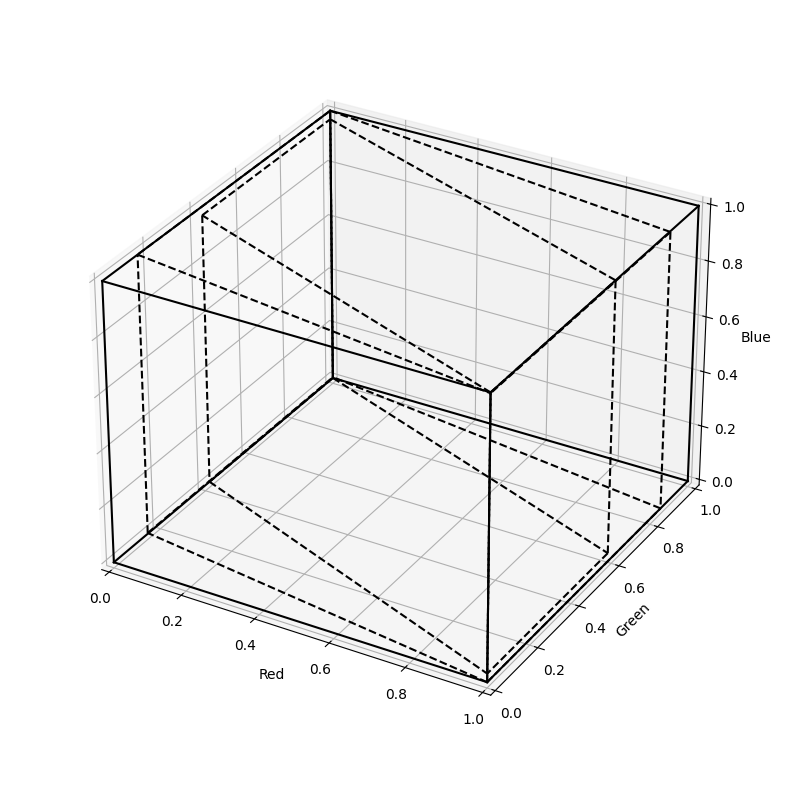

In [72]:
M_2 = colour.blindness.matrix_cvd_Machado2009('Protanomaly', 1)
v_2 = compute_kernel(M_2)
anchor_1_2, anchor_2_2 = comute_anchor_points(v_2)
d_2, y_2, z_2 = compute_basis(v_2, anchor_1_2, anchor_2_2)
parallelepiped_vertices_2, parallelepiped_edges_2 = compute_parallelepiped(v_2, anchor_1_2, anchor_2_2, d_2, y_2, z_2)
ax = create_figure()
ax = plot_cube(ax)
ax = plot_parallelepiped(ax, parallelepiped_vertices, parallelepiped_edges)
ax = plot_parallelepiped(ax, parallelepiped_vertices_2, parallelepiped_edges_2)
plt.show();

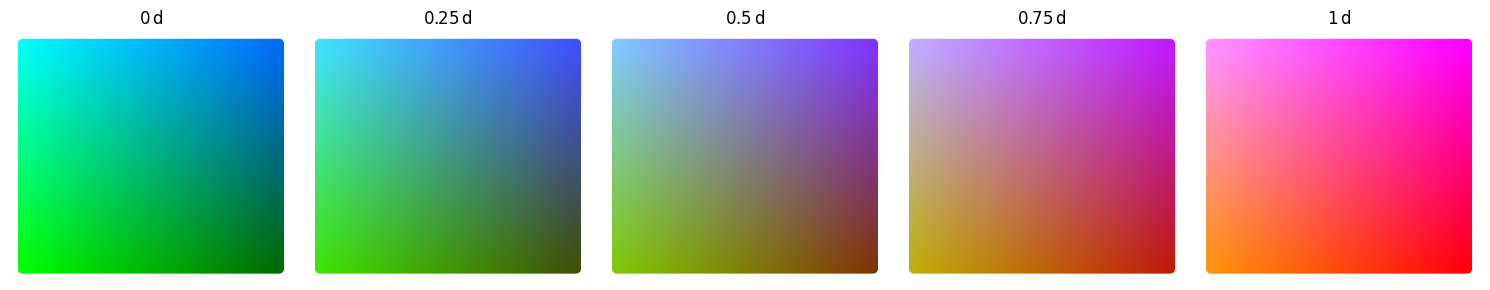

In [69]:
d_vals = np.linspace(0, 1, 5)

grid = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
color_grid = np.outer(grid[0].reshape(-1), y).reshape(-1, 3) + np.outer(grid[1].reshape(-1), z).reshape(-1, 3)

fig, ax = plt.subplots(1, len(d_vals), figsize=(3*len(d_vals), 3))

for idx, d_val in enumerate(d_vals):
    colors = anchor_1 + d_val * d * v + color_grid
    ax[idx].scatter(grid[0], grid[1], c= colors)
    ax[idx].set_title(f'{d_val:.2g}$\,$d')
    ax[idx].axis('off')

fig.tight_layout()
plt.show()    

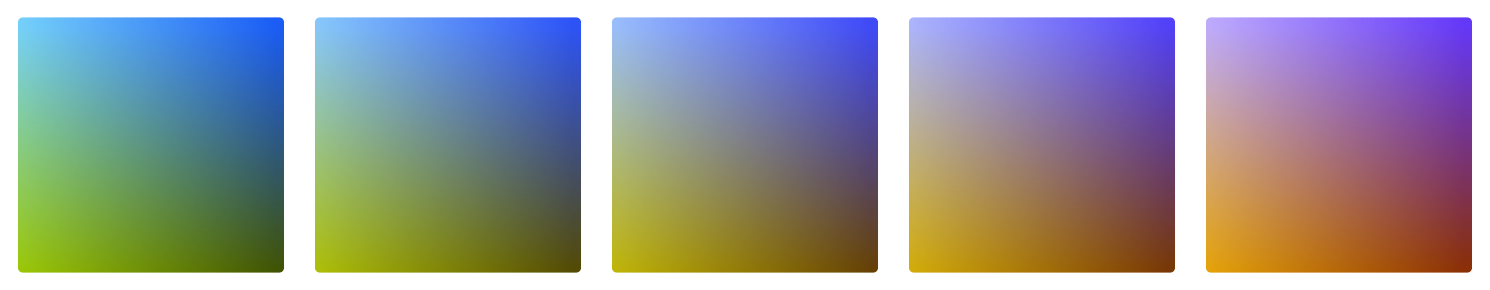

In [70]:
M = colour.blindness.matrix_cvd_Machado2009(cvd, .5)

fig, ax = plt.subplots(1, len(d_vals), figsize=(3*len(d_vals), 3))

for idx, d_val in enumerate(d_vals):
    colors = anchor_1 + d_val * d * v + color_grid
    colors = np.apply_along_axis(lambda x: M@x, 1, colors).clip(0, 1)
    ax[idx].scatter(grid[0], grid[1], c= colors)
    ax[idx].axis('off')

fig.tight_layout()
plt.show()    

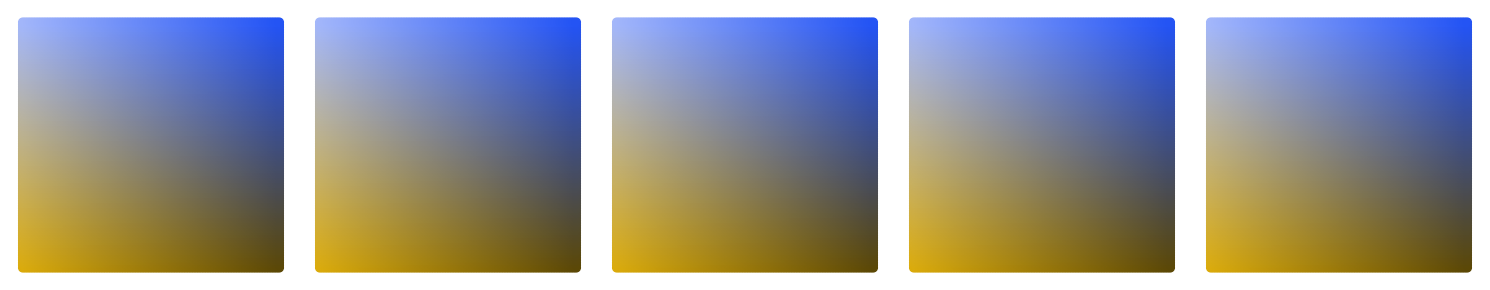

In [71]:
M = colour.blindness.matrix_cvd_Machado2009(cvd, 1)

color_grid = np.outer(grid[0].reshape(-1), y).reshape(-1, 3) + np.outer(grid[1].reshape(-1), z).reshape(-1, 3)

fig, ax = plt.subplots(1, len(d_vals), figsize=(3*len(d_vals), 3))

for idx, d_val in enumerate(d_vals):
    colors = anchor_1 + d_val * d * v + color_grid
    colors = np.apply_along_axis(lambda x: M@x, 1, colors)
    ax[idx].scatter(grid[0], grid[1], c= colors)
    ax[idx].axis('off')

fig.tight_layout()
plt.show()    